# Exploratory Data Analysis (EDA) - Swiss Hiking Trails

This notebook performs a comprehensive exploratory data analysis of Swiss hiking trails.

**Goals:**
- Non-graphical EDA: Descriptive statistics, frequencies, correlations
- Graphical EDA: 8 visualizations for data exploration
- Identification of patterns and relationships for modeling

## 1. Setup & Load Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import utility functions for cleaner code
from notebooks.utils.db_utils import read_from_db, setup_display_settings, setup_visualization_settings

# Setup display and visualization settings
setup_display_settings(float_format='{:.2f}', precision=2)
setup_visualization_settings()


Display settings configured
Visualization settings configured


In [2]:
# Load data from MySQL database using utility function
df = read_from_db("SELECT * FROM hiking_routes")

# Display first rows
df.head()

Loaded 375 rows, 13 columns from database


,url,title,location,canton,difficulty_level,difficulty_num,duration_min,distance_km,ascent_m,descent_m,physical_demand,latitude,longitude
0,https://www.schweizer-wanderwege.ch/de/wanderv...,Husky-Traum,Muotathal,None,None,NaN,NaN,0.00,NaN,NaN,hoch,46.97,8.77
1,https://www.schweizer-wanderwege.ch/de/wanderv...,Aufregende Ausblicke auf dem Hochalp Trail,"Urnäsch, Anker",AR,None,NaN,405.00,11.40,720.00,720.00,hoch,47.31,9.28
2,https://www.schweizer-wanderwege.ch/de/wanderv...,Den ganzen Tag im Schnee,"Atzmännig SSA — Atzmännig, Schutt",SG,None,NaN,100.00,4.20,140.00,510.00,mittel,NaN,NaN
3,https://www.schweizer-wanderwege.ch/de/wanderv...,Panorama Trail in Obwalden,Langis,OW,None,NaN,270.00,12.30,565.00,565.00,hoch,46.89,8.13
4,https://www.schweizer-wanderwege.ch/de/wanderv...,Schneeschuhwanderung auf den Chasseron,"Les Rasses, village",VD,None,NaN,260.00,10.00,450.00,450.00,hoch,46.83,6.55


## 2. Non-Graphical EDA

### 2.1 Descriptive Statistics for Numeric Variables

In [3]:
# Descriptive statistics for all numeric variables
numeric_cols = ['duration_min', 'distance_km', 'ascent_m', 'descent_m']

print("="*80)
print("DESCRIPTIVE STATISTICS - Numeric Variables")
print("="*80)

desc_stats = df[numeric_cols].describe().T
desc_stats['median'] = df[numeric_cols].median()
desc_stats = desc_stats[['count', 'mean', 'median', 'std', 'min', 'max']]

print(desc_stats)
print("\n")

# Interpretation
print("INTERPRETATION:")
print(f"- Average hiking duration: {df['duration_min'].mean():.0f} minutes ({df['duration_min'].mean()/60:.1f} hours)")
print(f"- Average distance: {df['distance_km'].mean():.1f} km")
print(f"- Average ascent: {df['ascent_m'].mean():.0f} m")
print(f"- Average descent: {df['descent_m'].mean():.0f} m")

DESCRIPTIVE STATISTICS - Numeric Variables
              count   mean  median    std   min     max
duration_min 372.00 182.18  175.00  75.10 35.00  435.00
distance_km  375.00   8.72    8.40   3.73  0.00   24.30
ascent_m     373.00 314.03  290.00 187.99  0.00 1080.00
descent_m    372.00 351.10  315.00 221.82  5.00 1310.00


INTERPRETATION:
- Average hiking duration: 182 minutes (3.0 hours)
- Average distance: 8.7 km
- Average ascent: 314 m
- Average descent: 351 m


### 2.2 Top 5 Cantons with Most Hiking Trails

In [4]:
print("="*80)
print("FREQUENCY DISTRIBUTION - Top 5 Cantons")
print("="*80)

canton_counts = df['canton'].value_counts().head(5)
canton_percentage = (canton_counts / len(df) * 100).round(1)

canton_df = pd.DataFrame({
    'Number of Trails': canton_counts,
    'Percent (%)': canton_percentage
})

print(canton_df)
print(f"\n The top 5 cantons represent {canton_percentage.sum():.1f}% of all hiking trails")

FREQUENCY DISTRIBUTION - Top 5 Cantons
        Number of Trails  Percent (%)
canton                               
BE                    65        17.30
VS                    48        12.80
GR                    47        12.50
VD                    26         6.90
TI                    26         6.90

 The top 5 cantons represent 56.4% of all hiking trails


### 2.3 Correlation Matrix (Numeric Variables)

In [5]:
print("="*80)
print("CORRELATION MATRIX - Pearson Correlation")
print("="*80)

correlation_matrix = df[numeric_cols].corr()
print(correlation_matrix.round(3))

print("\nINTERPRETATION:")
print("Values close to 1/-1 = strong correlation, close to 0 = weak correlation")

# Find strongest correlations (excluding diagonal)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append((
            correlation_matrix.columns[i],
            correlation_matrix.columns[j],
            correlation_matrix.iloc[i, j]
        ))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

print("\nStrongest Correlations:")
for var1, var2, corr_val in corr_pairs_sorted[:3]:
    print(f"• {var1} <-> {var2}: {corr_val:.3f}")

CORRELATION MATRIX - Pearson Correlation
              duration_min  distance_km  ascent_m  descent_m
duration_min          1.00         0.78      0.74       0.70
distance_km           0.78         1.00      0.41       0.47
ascent_m              0.74         0.41      1.00       0.64
descent_m             0.70         0.47      0.64       1.00

INTERPRETATION:
Values close to 1/-1 = strong correlation, close to 0 = weak correlation

Strongest Correlations:
• duration_min <-> distance_km: 0.783
• duration_min <-> ascent_m: 0.737
• duration_min <-> descent_m: 0.697


### 2.4 Missing Values Check

In [6]:
print("="*80)
print("MISSING VALUES - Missing Values per Column")
print("="*80)

missing_data = pd.DataFrame({
    'Number Missing': df.isnull().sum(),
    'Percent (%)': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_data = missing_data[missing_data['Number Missing'] > 0].sort_values('Number Missing', ascending=False)

if len(missing_data) > 0:
    print(missing_data)
    print(f"\nColumns with missing values: {len(missing_data)}")
else:
    print("No missing values found!")

MISSING VALUES - Missing Values per Column
                  Number Missing  Percent (%)
difficulty_level             274        73.07
difficulty_num               274        73.07
latitude                      33         8.80
longitude                     33         8.80
duration_min                   3         0.80
canton                         3         0.80
descent_m                      3         0.80
ascent_m                       2         0.53

Columns with missing values: 8


### 2.5 Crosstab: Difficulty Level × Physical Demand

In [7]:
print("="*80)
print("CROSSTAB - Difficulty Level vs. Physical Demand")
print("="*80)

# Make a safe version of difficulty_level for crosstabs/plots
# (in the DB NULL may become NaN; treat both as missing)

def ordered_difficulty_levels(series):
    """Return a sorted list of difficulty levels (e.g. ['T1','T2',...])
    excluding None/NaN. Sorting is numeric by the number after 'T'."""
    import re
    vals = [v for v in pd.unique(series) if pd.notna(v) and v is not None]
    # cast to str (safety), keep only T<number> patterns
    def sort_key(s):
        m = re.match(r"^T(\d+)$", str(s))
        return int(m.group(1)) if m else 999
    vals = list(map(str, vals))
    return sorted(vals, key=sort_key)

crosstab = pd.crosstab(df['difficulty_level'], df['physical_demand'], margins=True)
print(crosstab)

print("\nPercentage Distribution (row-wise):")
crosstab_pct = pd.crosstab(df['difficulty_level'], df['physical_demand'], normalize='index') * 100
print(crosstab_pct.round(1))

CROSSTAB - Difficulty Level vs. Physical Demand
physical_demand   hoch  mittel  tief  All
difficulty_level                         
T1                   4      56    30   90
T2                   2       7     1   10
T3                   0       1     0    1
All                  6      64    31  101

Percentage Distribution (row-wise):
physical_demand   hoch  mittel  tief
difficulty_level                    
T1                4.40   62.20 33.30
T2               20.00   70.00 10.00
T3                0.00  100.00  0.00


## 3. Graphical EDA

### 3.1 Histogram: Distribution of Hiking Duration

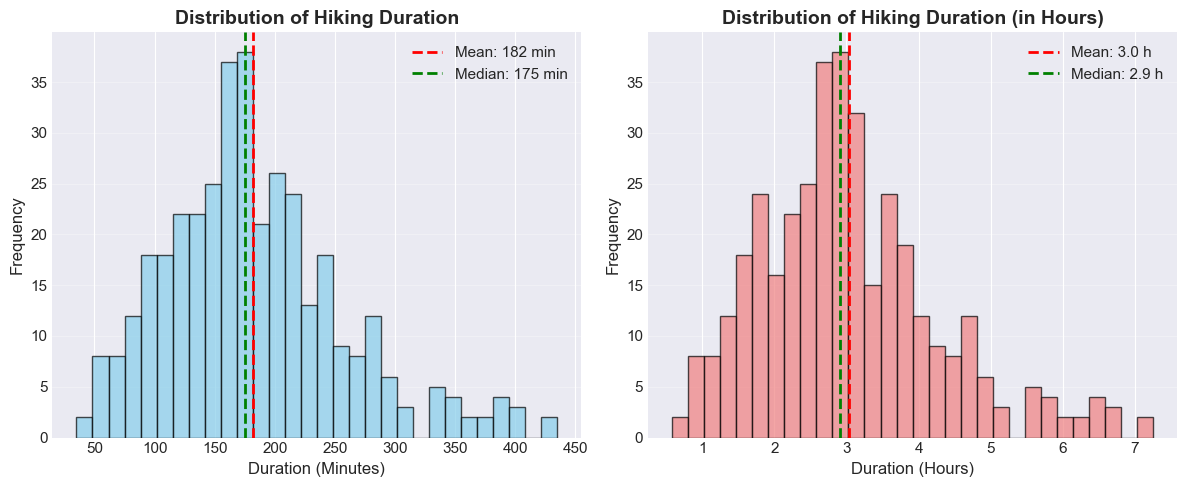

INTERPRETATION:
Most hikes last between 2.2 and 3.7 hours.


In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['duration_min'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(df['duration_min'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["duration_min"].mean():.0f} min')
plt.axvline(df['duration_min'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["duration_min"].median():.0f} min')
plt.xlabel('Duration (Minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Hiking Duration', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df['duration_min']/60, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(df['duration_min'].mean()/60, color='red', linestyle='--', linewidth=2, label=f'Mean: {df["duration_min"].mean()/60:.1f} h')
plt.axvline(df['duration_min'].median()/60, color='green', linestyle='--', linewidth=2, label=f'Median: {df["duration_min"].median()/60:.1f} h')
plt.xlabel('Duration (Hours)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Hiking Duration (in Hours)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print(f"Most hikes last between {df['duration_min'].quantile(0.25)/60:.1f} and {df['duration_min'].quantile(0.75)/60:.1f} hours.")

### 3.2 Boxplot: Distance by Difficulty Level

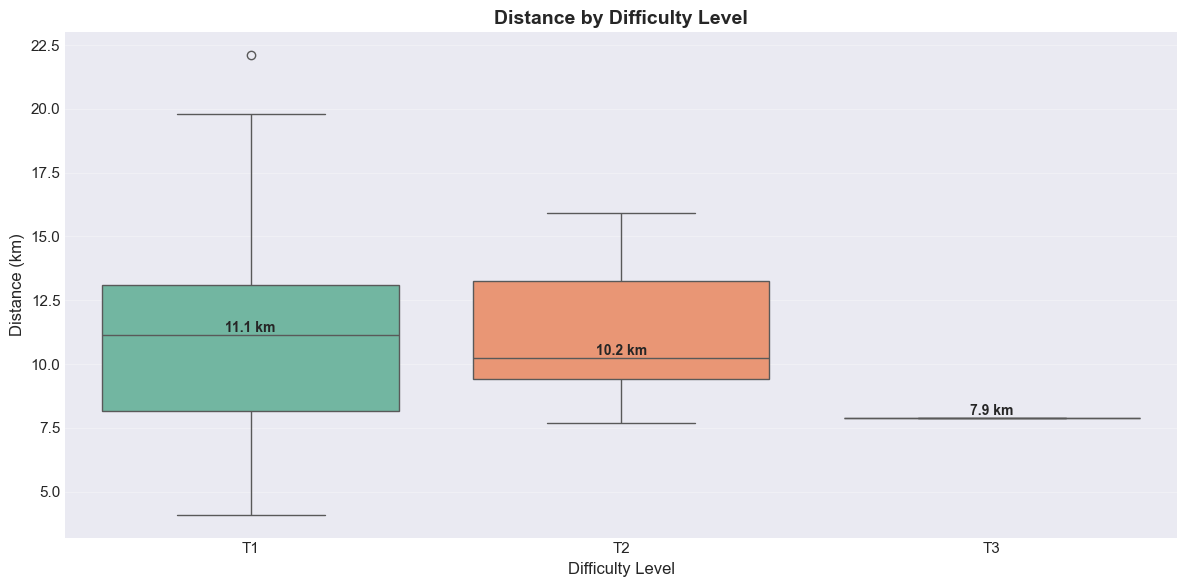

INTERPRETATION:
The box shows the middle 50% of the data (25%-75% quartile).
Outliers (points) show unusually long/short routes for the respective difficulty level.


In [9]:
plt.figure(figsize=(12, 6))

# Sort difficulty_level (safely, without None/NaN)
difficulty_order = ordered_difficulty_levels(df['difficulty_level'])

# Optional: set categorical dtype so seaborn respects order consistently
if difficulty_order:
    df['difficulty_level'] = pd.Categorical(df['difficulty_level'],
                                            categories=difficulty_order,
                                            ordered=True)

sns.boxplot(data=df, x='difficulty_level', y='distance_km', order=difficulty_order, palette='Set2')
plt.xlabel('Difficulty Level', fontsize=12)
plt.ylabel('Distance (km)', fontsize=12)
plt.title('Distance by Difficulty Level', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add median values
medians = df.groupby('difficulty_level')['distance_km'].median().reindex(difficulty_order)
for i, (level, median) in enumerate(medians.items()):
    # median can be NaN, skip in that case
    if pd.isna(median):
        continue
    plt.text(i, median, f'{median:.1f} km', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print("The box shows the middle 50% of the data (25%-75% quartile).")
print("Outliers (points) show unusually long/short routes for the respective difficulty level.")

### 3.3 Scatterplot: Distance vs. Duration (with Difficulty Level)

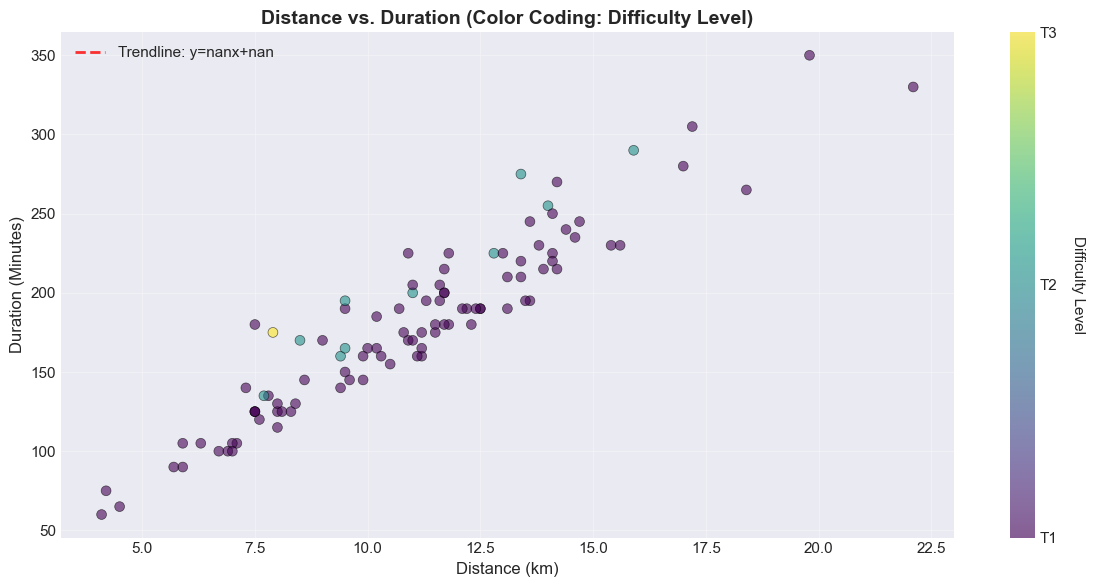

INTERPRETATION:
Correlation Distance <-> Duration: 0.783
Positive correlation means: Longer distances tend to require more time.


In [10]:
plt.figure(figsize=(12, 6))

# Create scatterplot with color coding by difficulty level
difficulty_order = ordered_difficulty_levels(df['difficulty_level'])
# build color map only for existing levels
difficulty_colors = {level: i for i, level in enumerate(difficulty_order)}
colors = df['difficulty_level'].map(difficulty_colors)

scatter = plt.scatter(df['distance_km'], df['duration_min'], c=colors, cmap='viridis',
                     alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Duration (Minutes)', fontsize=12)
plt.title('Distance vs. Duration (Color Coding: Difficulty Level)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Colorbar with labels (only if there is at least one level)
if difficulty_order:
    cbar = plt.colorbar(scatter, ticks=list(difficulty_colors.values()))
    cbar.ax.set_yticklabels(list(difficulty_colors.keys()))
    cbar.set_label('Difficulty Level', rotation=270, labelpad=20, fontsize=11)

# Add trendline
z = np.polyfit(df['distance_km'].dropna(), df.loc[df['distance_km'].notna(), 'duration_min'], 1)
p = np.poly1d(z)
plt.plot(df['distance_km'].sort_values(), p(df['distance_km'].sort_values()),
         "r--", linewidth=2, alpha=0.8, label=f'Trendline: y={z[0]:.1f}x+{z[1]:.1f}')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print(f"Correlation Distance <-> Duration: {df[['distance_km', 'duration_min']].corr().iloc[0,1]:.3f}")
print("Positive correlation means: Longer distances tend to require more time.")

### 3.4 Correlation Heatmap

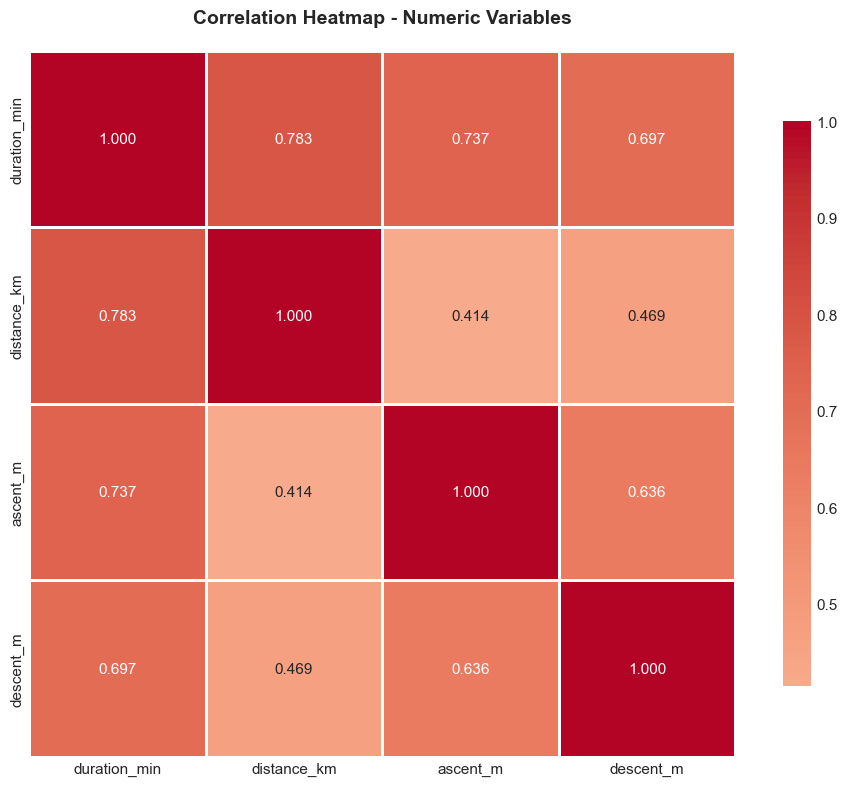

INTERPRETATION:
Red = positive correlation, Blue = negative correlation
Values close to +-1 show strong linear relationships.


In [11]:
plt.figure(figsize=(10, 8))

correlation_matrix = df[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap - Numeric Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print("Red = positive correlation, Blue = negative correlation")
print("Values close to +-1 show strong linear relationships.")

### 3.5 Barplot: Top 5 Cantons by Number of Hiking Trails

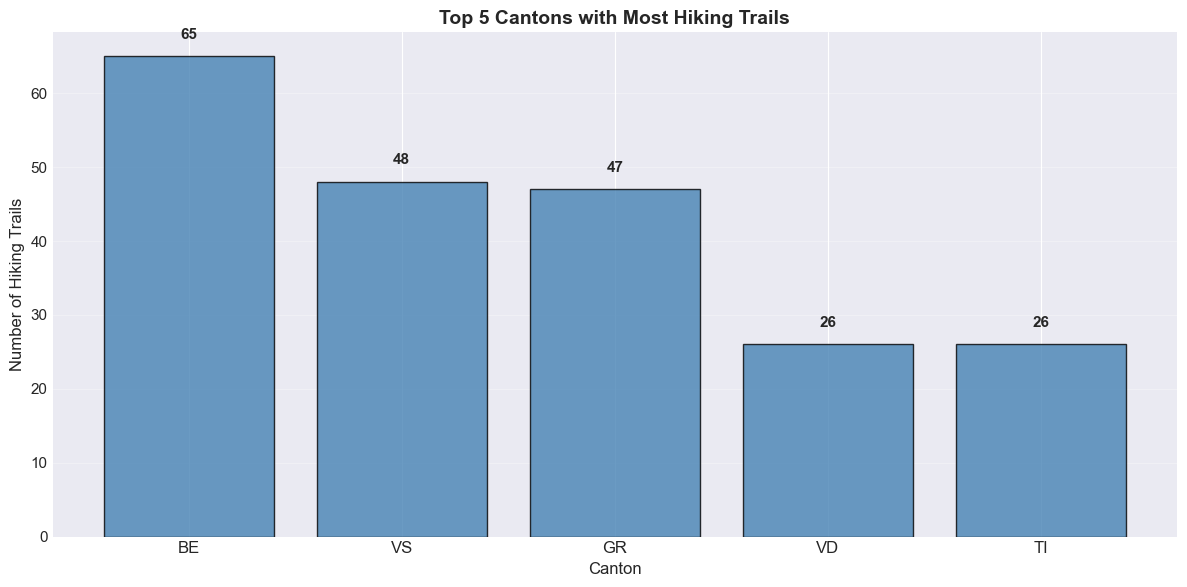

INTERPRETATION:
Canton BE leads with 65 hiking trails.


In [12]:
plt.figure(figsize=(12, 6))

top5_cantons = df['canton'].value_counts().head(5)

bars = plt.bar(range(len(top5_cantons)), top5_cantons.values,
               color='steelblue', edgecolor='black', alpha=0.8)

plt.xticks(range(len(top5_cantons)), top5_cantons.index, fontsize=12)
plt.xlabel('Canton', fontsize=12)
plt.ylabel('Number of Hiking Trails', fontsize=12)
plt.title('Top 5 Cantons with Most Hiking Trails', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Display values on bars
for i, (bar, value) in enumerate(zip(bars, top5_cantons.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print(f"Canton {top5_cantons.index[0]} leads with {top5_cantons.values[0]} hiking trails.")

### 3.6 Stacked Barplot: Difficulty Level Distribution per Canton (Top 5)

<Figure size 1200x600 with 0 Axes>

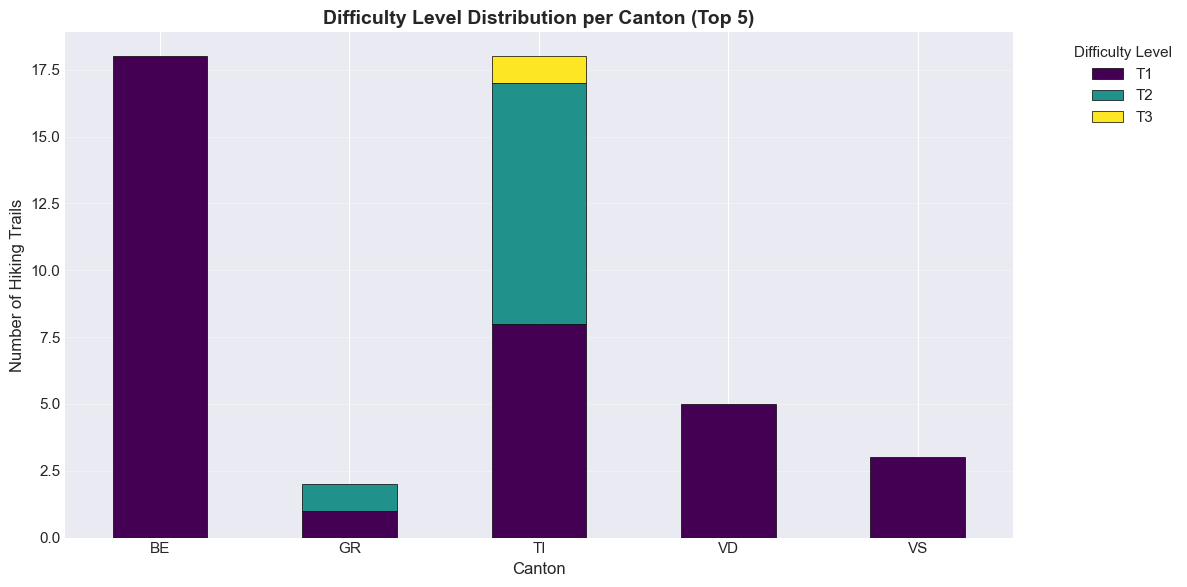

INTERPRETATION:
Shows the distribution of difficulty levels within the top 5 cantons.
Different colors = different difficulty levels (T1-T6).


In [13]:
# Select top 5 cantons
top5_cantons = df['canton'].value_counts().head(5).index
df_top5 = df[df['canton'].isin(top5_cantons)]

# Create crosstab for stacked bar
crosstab_difficulty = pd.crosstab(df_top5['canton'], df_top5['difficulty_level'])

# Sort difficulty levels (without None/NaN)
difficulty_cols = [col for col in crosstab_difficulty.columns if pd.notna(col) and col is not None]
# use the ordered helper to determine final order
ordered_levels = ordered_difficulty_levels(difficulty_cols)
if ordered_levels:
    crosstab_difficulty = crosstab_difficulty[ordered_levels]

plt.figure(figsize=(12, 6))

crosstab_difficulty.plot(kind='bar', stacked=True, figsize=(12, 6),
                         colormap='viridis', edgecolor='black', linewidth=0.5)

plt.xlabel('Canton', fontsize=12)
plt.ylabel('Number of Hiking Trails', fontsize=12)
plt.title('Difficulty Level Distribution per Canton (Top 5)', fontsize=14, fontweight='bold')
plt.legend(title='Difficulty Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print("Shows the distribution of difficulty levels within the top 5 cantons.")
print("Different colors = different difficulty levels (T1-T6).")

## 4. Summary of EDA Findings

In [14]:
print("="*80)
print("SUMMARY - Key Findings from EDA")
print("="*80)
print()
print("DATA OVERVIEW:")
print(f"- Number of hiking trails: {len(df)}")
print(f"- Number of cantons: {df['canton'].nunique()}")
print(f"- Difficulty levels: {ordered_difficulty_levels(df['difficulty_level'])}")
print()
print("NUMERIC RELATIONSHIPS:")
print(f"- Strongest correlation: {corr_pairs_sorted[0][0]} <-> {corr_pairs_sorted[0][1]} ({corr_pairs_sorted[0][2]:.3f})")
print(f"- Average hiking time: {df['duration_min'].mean()/60:.1f} hours")
print(f"- Average distance: {df['distance_km'].mean():.1f} km")
print()
print("ELEVATION PROFILES:")
print(f"- Average ascent: {df['ascent_m'].mean():.0f} m")
print(f"- Max. ascent: {df['ascent_m'].max():.0f} m")
print(f"- Correlation Ascent <-> Descent: {df[['ascent_m', 'descent_m']].corr().iloc[0,1]:.3f}")
print()
print("GEOGRAPHIC DISTRIBUTION:")
print(f"- Top 5 cantons: {', '.join(top5_cantons.tolist())}")
print(f"- Leading canton: {top5_cantons[0]} ({canton_counts.iloc[0]} hiking trails)")
print()
print("EDA completed - Ready for modeling!")
print("="*80)

SUMMARY - Key Findings from EDA

DATA OVERVIEW:
- Number of hiking trails: 375
- Number of cantons: 26
- Difficulty levels: ['T1', 'T2', 'T3']

NUMERIC RELATIONSHIPS:
- Strongest correlation: duration_min <-> distance_km (0.783)
- Average hiking time: 3.0 hours
- Average distance: 8.7 km

ELEVATION PROFILES:
- Average ascent: 314 m
- Max. ascent: 1080 m
- Correlation Ascent <-> Descent: 0.636

GEOGRAPHIC DISTRIBUTION:
- Top 5 cantons: BE, VS, GR, VD, TI
- Leading canton: BE (65 hiking trails)

EDA completed - Ready for modeling!


### Jupyter notebook --footer info--

In [15]:
import os
import platform
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')


-----------------------------------
NT
Windows | 11
Datetime: 2026-01-05 21:08:21
Python Version: 3.14.0
-----------------------------------
